# Implementing CNN using PyTorch and Numpy
### We will:
* Understand CNN
* Use Numpy and PyTorch to build ConvNets
* Better understanding of Numpy and Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# We use GPU
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dtype = torch.float32

### We use our toy dataset -- CIFAR-10 to complete our training, validating and testing
### So we need to load CIFAR-10 data from torchvision first.

In [4]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])


cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Now you should see that the data has been loaded for you
* Now we proceed to our next step:**Using PyTorch API to build our first Convolutional Neural Network**
* As ususal, we will use the PyTorch's second layer of abstraction to build our ConvNet first.
**For those of you who are not familiar with PyTorch's three layers of abstraction, here's a chart:**

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |



**As a warm-up, we'll first try with the simplest three layer ConvNet before we dive deep into those famous implementation**

The structure of our vanilla cnn:
1. Conv Layer with #channel_1 channels, stride of 1, receptive field of 5x5 and 2 zero-padding
2. ReLU layer
3. Conv Layer with #channel_2 channels, stride of 1, receptive field of 3x3 and 1 zero-padding
4. ReLU layer
5. Fully Connected Layer\
For documentation: https://pytorch.org/docs/stable/index.html

In [8]:
# The shape of our input is N, C, H, W
import torch.nn.functional as F

def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        self.conv2d_first = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        nn.init.kaiming_normal_(self.conv2d_first.weight)

        self.conv2d_second = nn.Conv2d(channel_1, channel_2, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2d_second.weight)

        self.fc = nn.Linear(32 * 32 * channel_2, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)
    
    def forward(self, x):
        first_conv = F.relu(self.conv2d_first(x))
        second_conv = F.relu(self.conv2d_second(first_conv))
        second_conv = flatten(second_conv)
        score = self.fc(second_conv)

        return score

def testThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)
    model = ThreeLayerConvNet(3, 32, 32, 10)
    score = model(x)
    return score.size()
testThreeLayerConvNet()

torch.Size([64, 10])

Now that we have implemented a vanilla CNN, we need to implement training and testing methods.

In [9]:
def check_accuracy_module(model, loader):
    if loader.dataset.train:
        print("Checking accuracy on validation set")
    else:
        print("Checking accuracy on test set")

    num_correct = 0
    num_samples = 0

    model.eval()    # Set the model to validation mode
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            score = model(x)

            _, y_pred = score.max(1)
            num_correct += (y_pred == y).sum()
            num_samples += y.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print()

In [14]:
def train_module(model, optimizer, epochs=1, print_every=8):
    model = model.to(device=device)

    loss_his = []
    for e in range(epochs):
        for i, (x, y) in enumerate(loader_train):
            # Compute the score
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            score = model(x)

            loss = F.cross_entropy(score, y)
            loss_his.append(loss.item())

            # Zero out the gradient before update
            optimizer.zero_grad()

            # Backprop through the computational graph
            loss.backward()

            # Update the parameters of the model
            optimizer.step()

            if i % print_every == 0:
                print("Iteration %d, loss = %.4f" % (i, loss.item()))
                print()
        print("Epoch %d" % e)
        check_accuracy_module(model, loader_val)
    
    plt.xlabel("Iteration")
    plt.title("Loss History")
    plt.plot(loss_his)
    plt.legend(loc="best")
    plt.show()    
    

Iteration 0, loss = 4.1069

Iteration 80, loss = 2.2253

Iteration 160, loss = 2.3083

Iteration 240, loss = 1.9427

Iteration 320, loss = 1.9564

Iteration 400, loss = 1.9098

Iteration 480, loss = 1.7638

Iteration 560, loss = 1.5074

Iteration 640, loss = 1.5998

Iteration 720, loss = 1.7469

Epoch 0
Checking accuracy on validation set


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Got 452 / 1000 correct (45.20)



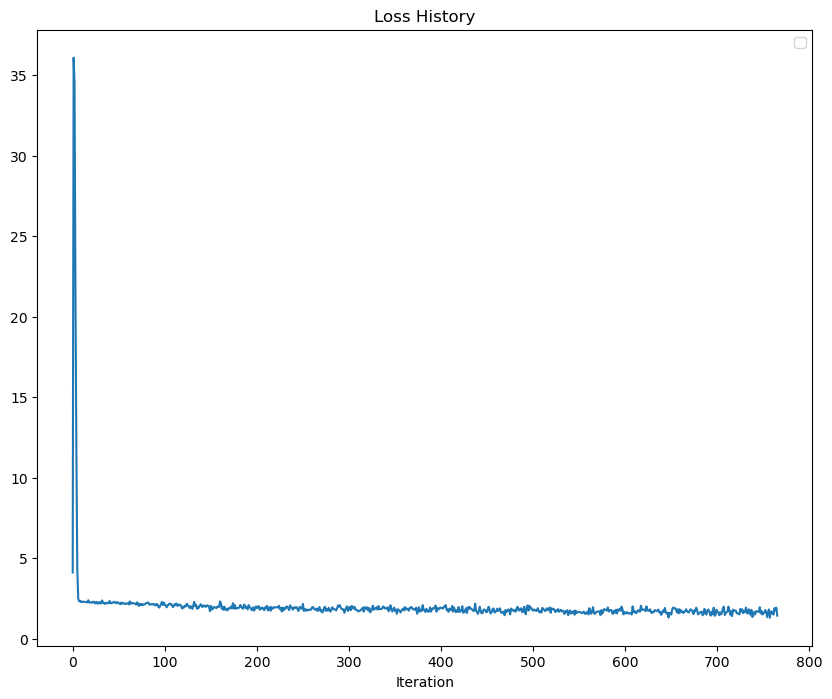

In [16]:
model = ThreeLayerConvNet(3, 32, 32, 10)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

train_module(model, optimizer, epochs=1, print_every=80)

**Now that we have implemented CNN using the second layer of abstraction, we now use the Sequential Layer to implement CNN (Super fast)**

Iteration 0, loss = 2.2987

Iteration 320, loss = 1.6598

Iteration 640, loss = 1.6839

Epoch 0
Checking accuracy on validation set
Got 497 / 1000 correct (49.70)

Iteration 0, loss = 1.5397

Iteration 320, loss = 1.7281

Iteration 640, loss = 1.4238

Epoch 1
Checking accuracy on validation set
Got 542 / 1000 correct (54.20)

Iteration 0, loss = 1.2811

Iteration 320, loss = 1.2123

Iteration 640, loss = 1.0307

Epoch 2
Checking accuracy on validation set
Got 549 / 1000 correct (54.90)

Iteration 0, loss = 1.1249

Iteration 320, loss = 1.1853

Iteration 640, loss = 1.2853

Epoch 3
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)

Iteration 0, loss = 1.0138

Iteration 320, loss = 1.0200

Iteration 640, loss = 1.2254

Epoch 4
Checking accuracy on validation set
Got 594 / 1000 correct (59.40)

Iteration 0, loss = 1.0361

Iteration 320, loss = 1.0970

Iteration 640, loss = 0.9623

Epoch 5
Checking accuracy on validation set
Got 609 / 1000 correct (60.90)

Iteration 0, los

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Got 634 / 1000 correct (63.40)



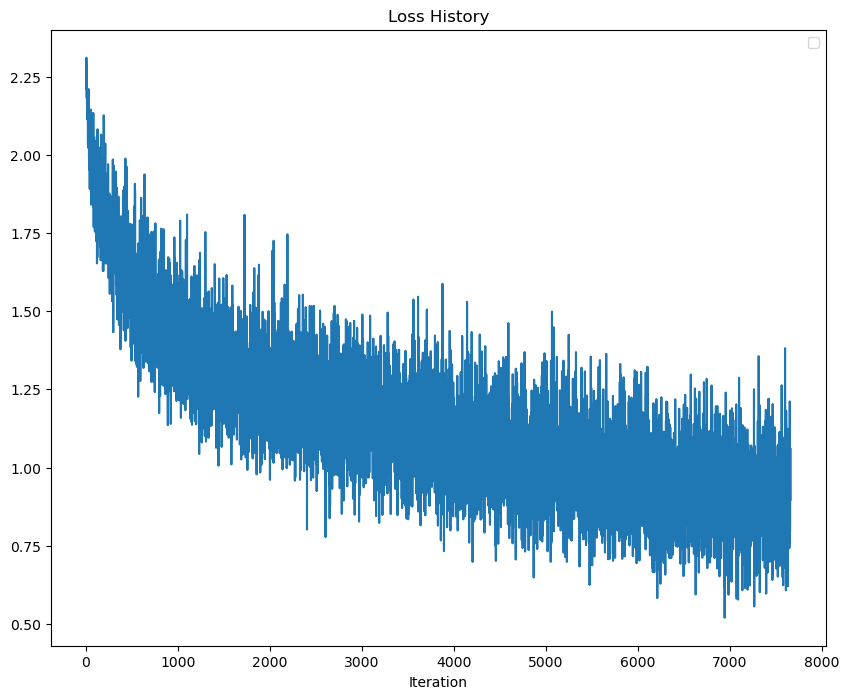

In [18]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

channel_1 = 64
channel_2 = 64
num_classes = 10

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, num_classes)
)

optimizer = optim.SGD(model.parameters(), lr=3e-3)
train_module(model, optimizer, epochs=10, print_every=320)